- https://jfan001.medium.com/how-we-cut-the-rate-of-gpt-hallucinations-from-20-to-less-than-2-f3bfcc10e4ec
- https://cookbook.openai.com/examples/using_logprobs

$$
\begin{split}
&\text{logp}=\log(p)\\
&p=\exp(\log(p))
\end{split}
$$

- `logprobs`: the API returns the log probabilities of **each output** token, along with a limited number of the most likely tokens at each token position and their log probabilities.
    - `logprobs`: Whether to return log probabilities of the output tokens or not. If true, returns the log probabilities of each output token returned in the content of message. This option is currently not available on the gpt-4-vision-preview model.
    - `top_logprobs`: An integer between 0 and 5 specifying the number of most likely tokens to return at each token position, each with an associated log probability. logprobs must be set to true if this parameter is used.
- 数值分析 & 应用
    - $0 \leq p\leq 1 \rightarrow \log (p)\leq 0$
    - Logprob can be any negative number or 0.0. 0.0 corresponds to 100% probability.
    - Logprobs allow us to compute the **joint probability** of a sequence as the sum of the logprobs of the individual tokens. This is useful for scoring and ranking model outputs. Another common approach is to take the average per-token logprob of a sentence to choose the best generation.
        - $\log P(S)=\log P(x_1,x_2,...,x_n)=\sum_i \log (x_i|x_{\lt x_{i-1}})$
        - $\frac1n\sum_i\log P(x_i|x_{<i})$

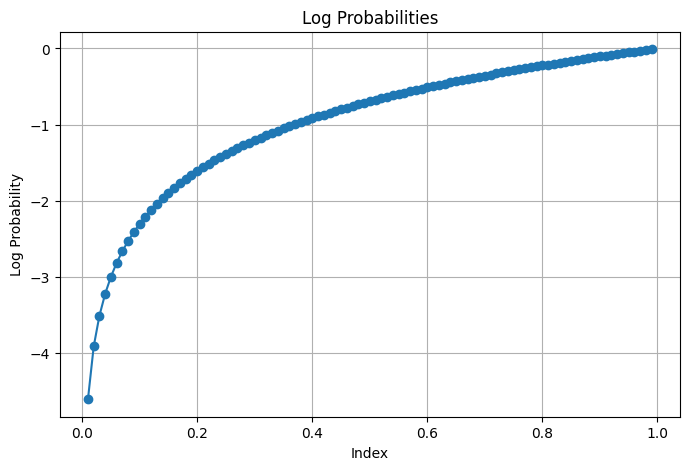

In [1]:
import numpy as np
import matplotlib.pyplot as plt

probs = np.arange(0.01, 1, 0.01)
log_ps = np.log(probs)

plt.figure(figsize=(8, 5))
plt.plot(probs, log_ps, marker='o')
plt.title('Log Probabilities')
plt.xlabel('Index')
plt.ylabel('Log Probability')
plt.grid()
plt.show()

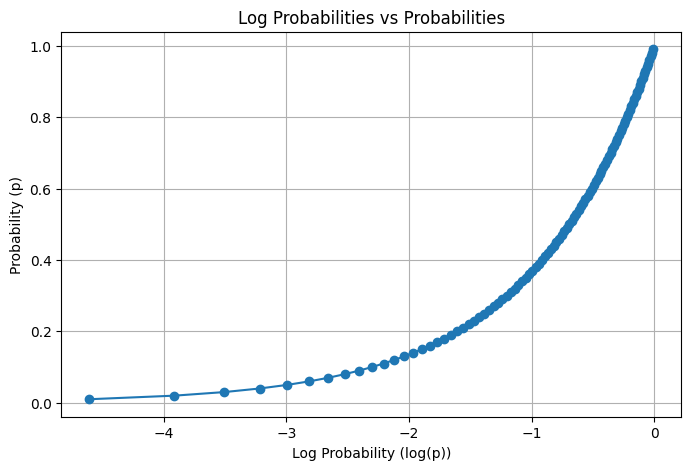

In [30]:
# Example probabilities (ensure no zero values to avoid log issues)
p = np.arange(0.01, 1, 0.01)
logp = np.log(p)

# Plot: x-axis is log(p), y-axis is p
plt.figure(figsize=(8, 5))
plt.plot(logp, p, marker='o')
plt.title('Log Probabilities vs Probabilities')
plt.xlabel('Log Probability (log(p))')
plt.ylabel('Probability (p)')
plt.grid()
plt.show()

In [2]:
# !pip install -U openai

In [3]:
from openai import OpenAI
from math import exp
import numpy as np
from IPython.display import display, HTML
import os

In [5]:
from dotenv import load_dotenv
assert load_dotenv()

In [7]:
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

In [8]:
def get_completion(
    messages: list[dict[str, str]],
    model: str = "gpt-4o-2024-08-06",
    max_tokens=500,
    temperature=0,
    stop=None,
    seed=123,
    tools=None,
    logprobs=None,  # whether to return log probabilities of the output tokens or not. If true, returns the log probabilities of each output token returned in the content of message..
    top_logprobs=None,
) -> str:
    params = {
        "model": model,
        "messages": messages,
        "max_tokens": max_tokens,
        "temperature": temperature,
        "stop": stop,
        "seed": seed,
        "logprobs": logprobs,
        "top_logprobs": top_logprobs,
    }
    if tools:
        params["tools"] = tools

    completion = client.chat.completions.create(**params)
    return completion

### 1. Using logprobs to assess confidence for classification tasks

- Let's say we want to create a system to classify news articles into a set of pre-defined categories. Without logprobs, we can use Chat Completions to do this, but it is much more difficult to **assess the certainty** with which the model made its classifications.
- Now, with logprobs enabled, we can see exactly **how confident** the model is in its predictions, which is crucial for creating an accurate and trustworthy classifier.
    - For example, if the log probability for the chosen category is high, this suggests the model is quite confident in its classification.
    - If it's low, this suggests the model is less confident.
    - This can be particularly useful in cases where the model's classification is not what you expected, or when the model's output needs to be reviewed or validated by a human.

In [9]:
CLASSIFICATION_PROMPT = """You will be given a headline of a news article.
Classify the article into one of the following categories: Technology, Politics, Sports, and Art.
Return only the name of the category, and nothing else.
MAKE SURE your output is one of the four categories stated.
Article headline: {headline}"""

In [10]:
headlines = [
    "Tech Giant Unveils Latest Smartphone Model with Advanced Photo-Editing Features.",
    "Local Mayor Launches Initiative to Enhance Urban Public Transport.",
    "Tennis Champion Showcases Hidden Talents in Symphony Orchestra Debut",
]

In [11]:
for headline in headlines:
    print(f"\nHeadline: {headline}")
    API_RESPONSE = get_completion(
        [{"role": "user", "content": CLASSIFICATION_PROMPT.format(headline=headline)}],
    )
    print(f"Category: {API_RESPONSE.choices[0].message.content}\n")


Headline: Tech Giant Unveils Latest Smartphone Model with Advanced Photo-Editing Features.
Category: Technology


Headline: Local Mayor Launches Initiative to Enhance Urban Public Transport.
Category: Politics


Headline: Tennis Champion Showcases Hidden Talents in Symphony Orchestra Debut
Category: Art



In [21]:
from rich.pretty import pprint
pprint(
get_completion(
        [{"role": "user", "content": CLASSIFICATION_PROMPT.format(headline='Tech Giant Unveils Latest Smartphone Model with Advanced Photo-Editing Features.')}],
        logprobs=True,
        top_logprobs=2,
    )
)

ChatCompletion(
│   id='chatcmpl-AbRmzsYyvSmgWYf8udpB4fdnOxPyb',
│   choices=[
│   │   Choice(
│   │   │   finish_reason='stop',
│   │   │   index=0,
│   │   │   logprobs=ChoiceLogprobs(
│   │   │   │   content=[
│   │   │   │   │   ChatCompletionTokenLogprob(
│   │   │   │   │   │   token='Technology',
│   │   │   │   │   │   bytes=[84, 101, 99, 104, 110, 111, 108, 111, 103, 121],
│   │   │   │   │   │   logprob=0.0,
│   │   │   │   │   │   top_logprobs=[
│   │   │   │   │   │   │   TopLogprob(
│   │   │   │   │   │   │   │   token='Technology',
│   │   │   │   │   │   │   │   bytes=[84, 101, 99, 104, 110, 111, 108, 111, 103, 121],
│   │   │   │   │   │   │   │   logprob=0.0
│   │   │   │   │   │   │   ),
│   │   │   │   │   │   │   TopLogprob(
│   │   │   │   │   │   │   │   token=' Technology',
│   │   │   │   │   │   │   │   bytes=[32, 84, 101, 99, 104, 110, 111, 108, 111, 103, 121],
│   │   │   │   │   │   │   │   logprob=-19.375
│   │   │   │   │   │   │   )
│   │   │   │   │   │   ]
│   │   │   │   │   )
│   │   │   │   ],
│   │   │   │   refusal=None
│   │   │   ),
│   │   │   message=ChatCompletionMessage(
│   │   │   │   content='Technology',
│   │   │   │   refusal=None,
│   │   │   │   role='assistant',
│   │   │   │   audio=None,
│   │   │   │   function_call=None,
│   │   │   │   tool_calls=None
│   │   │   )
│   │   )
│   ],
│   created=1733488321,
│   model='gpt-4o-2024-08-06',
│   object='chat.completion',
│   service_tier=None,
│   system_fingerprint='fp_c7ca0ebaca',
│   usage=CompletionUsage(
│   │   completion_tokens=1,
│   │   prompt_tokens=81,
│   │   total_tokens=82,
│   │   completion_tokens_details=CompletionTokensDetails(
│   │   │   accepted_prediction_tokens=0,
│   │   │   audio_tokens=0,
│   │   │   reasoning_tokens=0,
│   │   │   rejected_prediction_tokens=0
│   │   ),
│   │   prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)
│   )
)

In [61]:
bytes([84, 101, 99, 104, 110, 111, 108, 111, 103, 121]).decode("utf-8")

'Technology'

In [19]:
for headline in headlines:
    print(f"\nHeadline: {headline}")
    API_RESPONSE = get_completion(
        [{"role": "user", "content": CLASSIFICATION_PROMPT.format(headline=headline)}],
        logprobs=True,
        top_logprobs=2,
    )
    generated_response = API_RESPONSE.choices[0].message.content.replace('\n', '<br>')
    top_two_logprobs = API_RESPONSE.choices[0].logprobs.content[0].top_logprobs
    html_content = (
        f"<span style='color: green'>Generated response:</span> {generated_response}<br>"
    )
    for i, logprob in enumerate(top_two_logprobs, start=1):
        html_content += (
            f"<span style='color: cyan'>Output token {i}:</span> '{logprob.token}', "
            f"<span style='color: darkorange'>logprobs:</span> {logprob.logprob}, "
            f"<span style='color: magenta'>linear probability:</span> {np.round(np.exp(logprob.logprob)*100,2)}%<br>"
        )
    display(HTML(html_content))
    print("\n")


Headline: Tech Giant Unveils Latest Smartphone Model with Advanced Photo-Editing Features.





Headline: Local Mayor Launches Initiative to Enhance Urban Public Transport.





Headline: Tennis Champion Showcases Hidden Talents in Symphony Orchestra Debut


### 2. Retrieval confidence scoring to reduce hallucinations

- To reduce hallucinations, and the performance of our RAG-based Q&A system, we can use logprobs to evaluate how confident the model is in its retrieval.

- Let's say we have built a retrieval system using RAG for Q&A, but are struggling with hallucinated answers to our questions. Note: we will use a hardcoded article for this example, but see other entries in the cookbook for tutorials on using RAG for Q&A.

In [22]:
# Article retrieved
ada_lovelace_article = """Augusta Ada King, Countess of Lovelace (née Byron; 10 December 1815 – 27 November 1852) was an English mathematician and writer, chiefly known for her work on Charles Babbage's proposed mechanical general-purpose computer, the Analytical Engine. She was the first to recognise that the machine had applications beyond pure calculation.
Ada Byron was the only legitimate child of poet Lord Byron and reformer Lady Byron. All Lovelace's half-siblings, Lord Byron's other children, were born out of wedlock to other women. Byron separated from his wife a month after Ada was born and left England forever. He died in Greece when Ada was eight. Her mother was anxious about her upbringing and promoted Ada's interest in mathematics and logic in an effort to prevent her from developing her father's perceived insanity. Despite this, Ada remained interested in him, naming her two sons Byron and Gordon. Upon her death, she was buried next to him at her request. Although often ill in her childhood, Ada pursued her studies assiduously. She married William King in 1835. King was made Earl of Lovelace in 1838, Ada thereby becoming Countess of Lovelace.
Her educational and social exploits brought her into contact with scientists such as Andrew Crosse, Charles Babbage, Sir David Brewster, Charles Wheatstone, Michael Faraday, and the author Charles Dickens, contacts which she used to further her education. Ada described her approach as "poetical science" and herself as an "Analyst (& Metaphysician)".
When she was eighteen, her mathematical talents led her to a long working relationship and friendship with fellow British mathematician Charles Babbage, who is known as "the father of computers". She was in particular interested in Babbage's work on the Analytical Engine. Lovelace first met him in June 1833, through their mutual friend, and her private tutor, Mary Somerville.
Between 1842 and 1843, Ada translated an article by the military engineer Luigi Menabrea (later Prime Minister of Italy) about the Analytical Engine, supplementing it with an elaborate set of seven notes, simply called "Notes".
Lovelace's notes are important in the early history of computers, especially since the seventh one contained what many consider to be the first computer program—that is, an algorithm designed to be carried out by a machine. Other historians reject this perspective and point out that Babbage's personal notes from the years 1836/1837 contain the first programs for the engine. She also developed a vision of the capability of computers to go beyond mere calculating or number-crunching, while many others, including Babbage himself, focused only on those capabilities. Her mindset of "poetical science" led her to ask questions about the Analytical Engine (as shown in her notes) examining how individuals and society relate to technology as a collaborative tool.
"""

# Questions that can be easily answered given the article
easy_questions = [
    "What nationality was Ada Lovelace?",
    "What was an important finding from Lovelace's seventh note?",
]

# Questions that are not fully covered in the article
medium_questions = [
    "Did Lovelace collaborate with Charles Dickens",
    "What concepts did Lovelace build with Charles Babbage",
]

In [23]:
# JUST
PROMPT = """You retrieved this article: {article}. The question is: {question}.
Before even answering the question, consider whether you have sufficient information in the article to answer the question fully.
Your output should JUST be the boolean true or false, of if you have sufficient information in the article to answer the question.
Respond with just one word, the boolean true or false. You must output the word 'True', or the word 'False', nothing else.
"""

In [25]:
API_RESPONSE = get_completion(
        [
            {
                "role": "user",
                "content": PROMPT.format(
                    article=ada_lovelace_article, question="Did Lovelace collaborate with Charles Dickens"
                ),
            }
        ],
        model="gpt-4",
        logprobs=True,
    )

In [26]:
pprint(API_RESPONSE)

ChatCompletion(
│   id='chatcmpl-AbRtxaI8UkXs9rrr7PCJBS3pAhkc3',
│   choices=[
│   │   Choice(
│   │   │   finish_reason='stop',
│   │   │   index=0,
│   │   │   logprobs=ChoiceLogprobs(
│   │   │   │   content=[
│   │   │   │   │   ChatCompletionTokenLogprob(
│   │   │   │   │   │   token='True',
│   │   │   │   │   │   bytes=[84, 114, 117, 101],
│   │   │   │   │   │   logprob=-0.06760397,
│   │   │   │   │   │   top_logprobs=[]
│   │   │   │   │   )
│   │   │   │   ],
│   │   │   │   refusal=None
│   │   │   ),
│   │   │   message=ChatCompletionMessage(
│   │   │   │   content='True',
│   │   │   │   refusal=None,
│   │   │   │   role='assistant',
│   │   │   │   audio=None,
│   │   │   │   function_call=None,
│   │   │   │   tool_calls=None
│   │   │   )
│   │   )
│   ],
│   created=1733488753,
│   model='gpt-4-0613',
│   object='chat.completion',
│   service_tier=None,
│   system_fingerprint=None,
│   usage=CompletionUsage(
│   │   completion_tokens=1,
│   │   prompt_tokens=698,
│   │   total_tokens=699,
│   │   completion_tokens_details=CompletionTokensDetails(
│   │   │   accepted_prediction_tokens=0,
│   │   │   audio_tokens=0,
│   │   │   reasoning_tokens=0,
│   │   │   rejected_prediction_tokens=0
│   │   ),
│   │   prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)
│   )
)

In [28]:
pprint(get_completion(
        [
            {
                "role": "user",
                "content": PROMPT.format(
                    article=ada_lovelace_article, question=question
                ),
            }
        ],
        model="gpt-4",
        logprobs=True,
        top_logprobs=3,
    )
)

ChatCompletion(
│   id='chatcmpl-AbRxyt8e62V0e5cMdR3y4b3DBUbMX',
│   choices=[
│   │   Choice(
│   │   │   finish_reason='stop',
│   │   │   index=0,
│   │   │   logprobs=ChoiceLogprobs(
│   │   │   │   content=[
│   │   │   │   │   ChatCompletionTokenLogprob(
│   │   │   │   │   │   token='True',
│   │   │   │   │   │   bytes=[84, 114, 117, 101],
│   │   │   │   │   │   logprob=-0.51145124,
│   │   │   │   │   │   top_logprobs=[
│   │   │   │   │   │   │   TopLogprob(token='True', bytes=[84, 114, 117, 101], logprob=-0.51145124),
│   │   │   │   │   │   │   TopLogprob(token='False', bytes=[70, 97, 108, 115, 101], logprob=-0.9153552),
│   │   │   │   │   │   │   TopLogprob(token='false', bytes=[102, 97, 108, 115, 101], logprob=-14.718182)
│   │   │   │   │   │   ]
│   │   │   │   │   )
│   │   │   │   ],
│   │   │   │   refusal=None
│   │   │   ),
│   │   │   message=ChatCompletionMessage(
│   │   │   │   content='True',
│   │   │   │   refusal=None,
│   │   │   │   role='assistant',
│   │   │   │   audio=None,
│   │   │   │   function_call=None,
│   │   │   │   tool_calls=None
│   │   │   )
│   │   )
│   ],
│   created=1733489002,
│   model='gpt-4-0613',
│   object='chat.completion',
│   service_tier=None,
│   system_fingerprint=None,
│   usage=CompletionUsage(
│   │   completion_tokens=1,
│   │   prompt_tokens=701,
│   │   total_tokens=702,
│   │   completion_tokens_details=CompletionTokensDetails(
│   │   │   accepted_prediction_tokens=0,
│   │   │   audio_tokens=0,
│   │   │   reasoning_tokens=0,
│   │   │   rejected_prediction_tokens=0
│   │   ),
│   │   prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)
│   )
)

In [24]:
html_output = ""
html_output += "Questions clearly answered in article"

for question in easy_questions:
    API_RESPONSE = get_completion(
        [
            {
                "role": "user",
                "content": PROMPT.format(
                    article=ada_lovelace_article, question=question
                ),
            }
        ],
        model="gpt-4",
        logprobs=True,
    )
    html_output += f'<p style="color:green">Question: {question}</p>'
    for logprob in API_RESPONSE.choices[0].logprobs.content:
        html_output += f'<p style="color:cyan">has_sufficient_context_for_answer: {logprob.token}, <span style="color:darkorange">logprobs: {logprob.logprob}, <span style="color:magenta">linear probability: {np.round(np.exp(logprob.logprob)*100,2)}%</span></p>'

html_output += "Questions only partially covered in the article"

for question in medium_questions:
    API_RESPONSE = get_completion(
        [
            {
                "role": "user",
                "content": PROMPT.format(
                    article=ada_lovelace_article, question=question
                ),
            }
        ],
        model="gpt-4",
        logprobs=True,
        top_logprobs=3,
    )
    html_output += f'<p style="color:green">Question: {question}</p>'
    for logprob in API_RESPONSE.choices[0].logprobs.content:
        html_output += f'<p style="color:cyan">has_sufficient_context_for_answer: {logprob.token}, <span style="color:darkorange">logprobs: {logprob.logprob}, <span style="color:magenta">linear probability: {np.round(np.exp(logprob.logprob)*100,2)}%</span></p>'

display(HTML(html_output))

In [27]:
html_output = ""
html_output += "Questions clearly answered in article"

for question in easy_questions:
    API_RESPONSE = get_completion(
        [
            {
                "role": "user",
                "content": PROMPT.format(
                    article=ada_lovelace_article, question=question
                ),
            }
        ],
        logprobs=True,
    )
    html_output += f'<p style="color:green">Question: {question}</p>'
    for logprob in API_RESPONSE.choices[0].logprobs.content:
        html_output += f'<p style="color:cyan">has_sufficient_context_for_answer: {logprob.token}, <span style="color:darkorange">logprobs: {logprob.logprob}, <span style="color:magenta">linear probability: {np.round(np.exp(logprob.logprob)*100,2)}%</span></p>'

html_output += "Questions only partially covered in the article"

for question in medium_questions:
    API_RESPONSE = get_completion(
        [
            {
                "role": "user",
                "content": PROMPT.format(
                    article=ada_lovelace_article, question=question
                ),
            }
        ],
        logprobs=True,
        top_logprobs=3,
    )
    html_output += f'<p style="color:green">Question: {question}</p>'
    for logprob in API_RESPONSE.choices[0].logprobs.content:
        html_output += f'<p style="color:cyan">has_sufficient_context_for_answer: {logprob.token}, <span style="color:darkorange">logprobs: {logprob.logprob}, <span style="color:magenta">linear probability: {np.round(np.exp(logprob.logprob)*100,2)}%</span></p>'

display(HTML(html_output))

### 3. Highlighter and bytes parameter

In [53]:
PROMPT = """What's the longest word in the English language?"""

API_RESPONSE = get_completion(
    [{"role": "user", "content": PROMPT}], logprobs=True, top_logprobs=5
)

In [60]:
# pprint(API_RESPONSE)

In [50]:
def highlight_text(api_response):
    colors = [
        "#FF00FF",  # Magenta
        "#008000",  # Green
        "#FF8C00",  # Dark Orange
        "#FF0000",  # Red
        "#0000FF",  # Blue
    ]
    tokens = api_response.choices[0].logprobs.content

    color_idx = 0  # Initialize color index
    html_output = ""  # Initialize HTML output
    for t in tokens:
        token_str = bytes(t.bytes).decode("utf-8")  # Decode bytes to string

        # Add colored token to HTML output
        html_output += f"<span style='color: {colors[color_idx]}'>{token_str}</span>"

        # Move to the next color
        color_idx = (color_idx + 1) % len(colors)
    display(HTML(html_output))  # Display HTML output
    print(f"Total number of tokens: {len(tokens)}")

In [52]:
highlight_text(API_RESPONSE)

Total number of tokens: 160


### 4. Autocomplete

- 自动补全，即预测（这也对齐了 GPT 的训练任务，预测下一个单词），预测即推理（reasoning），推理即智能；

In [31]:
sentence_list = [
    "My",
    "My least",
    "My least favorite",
    "My least favorite TV",
    "My least favorite TV show",
    "My least favorite TV show is",
    "My least favorite TV show is Breaking Bad",
]

In [55]:
PROMPT = """Complete this sentence. You are acting as auto-complete. Simply complete the sentence to the best of your ability, make sure it is just ONE sentence: {sentence}"""
API_RESPONSE = get_completion(
    [{"role": "user", "content": PROMPT.format(sentence='My least')}],
    model="gpt-4o-mini",
    logprobs=True,
    top_logprobs=3,
)

In [56]:
pprint(API_RESPONSE)

ChatCompletion(
│   id='chatcmpl-AbSIuBqXKn7m5VEi5IrGMV5KW0JHm',
│   choices=[
│   │   Choice(
│   │   │   finish_reason='stop',
│   │   │   index=0,
│   │   │   logprobs=ChoiceLogprobs(
│   │   │   │   content=[
│   │   │   │   │   ChatCompletionTokenLogprob(
│   │   │   │   │   │   token='My',
│   │   │   │   │   │   bytes=[77, 121],
│   │   │   │   │   │   logprob=-6.2656334e-05,
│   │   │   │   │   │   top_logprobs=[
│   │   │   │   │   │   │   TopLogprob(token='My', bytes=[77, 121], logprob=-6.2656334e-05),
│   │   │   │   │   │   │   TopLogprob(
│   │   │   │   │   │   │   │   token='favorite',
│   │   │   │   │   │   │   │   bytes=[102, 97, 118, 111, 114, 105, 116, 101],
│   │   │   │   │   │   │   │   logprob=-9.750063
│   │   │   │   │   │   │   ),
│   │   │   │   │   │   │   TopLogprob(token=' My', bytes=[32, 77, 121], logprob=-12.625063)
│   │   │   │   │   │   ]
│   │   │   │   │   ),
│   │   │   │   │   ChatCompletionTokenLogprob(
│   │   │   │   │   │   token=' least',
│   │   │   │   │   │   bytes=[32, 108, 101, 97, 115, 116],
│   │   │   │   │   │   logprob=0.0,
│   │   │   │   │   │   top_logprobs=[
│   │   │   │   │   │   │   TopLogprob(token=' least', bytes=[32, 108, 101, 97, 115, 116], logprob=0.0),
│   │   │   │   │   │   │   TopLogprob(token='least', bytes=[108, 101, 97, 115, 116], logprob=-18.25),
│   │   │   │   │   │   │   TopLogprob(token='Least', bytes=[76, 101, 97, 115, 116], logprob=-18.75)
│   │   │   │   │   │   ]
│   │   │   │   │   ),
│   │   │   │   │   ChatCompletionTokenLogprob(
│   │   │   │   │   │   token=' favorite',
│   │   │   │   │   │   bytes=[32, 102, 97, 118, 111, 114, 105, 116, 101],
│   │   │   │   │   │   logprob=-1.8624639e-06,
│   │   │   │   │   │   top_logprobs=[
│   │   │   │   │   │   │   TopLogprob(
│   │   │   │   │   │   │   │   token=' favorite',
│   │   │   │   │   │   │   │   bytes=[32, 102, 97, 118, 111, 114, 105, 116, 101],
│   │   │   │   │   │   │   │   logprob=-1.8624639e-06
│   │   │   │   │   │   │   ),
│   │   │   │   │   │   │   TopLogprob(
│   │   │   │   │   │   │   │   token=' favourite',
│   │   │   │   │   │   │   │   bytes=[32, 102, 97, 118, 111, 117, 114, 105, 116, 101],
│   │   │   │   │   │   │   │   logprob=-14.125002
│   │   │   │   │   │   │   ),
│   │   │   │   │   │   │   TopLogprob(
│   │   │   │   │   │   │   │   token=' preferred',
│   │   │   │   │   │   │   │   bytes=[32, 112, 114, 101, 102, 101, 114, 114, 101, 100],
│   │   │   │   │   │   │   │   logprob=-14.750002
│   │   │   │   │   │   │   )
│   │   │   │   │   │   ]
│   │   │   │   │   ),
│   │   │   │   │   ChatCompletionTokenLogprob(
│   │   │   │   │   │   token=' chore',
│   │   │   │   │   │   bytes=[32, 99, 104, 111, 114, 101],
│   │   │   │   │   │   logprob=-0.4413885,
│   │   │   │   │   │   top_logprobs=[
│   │   │   │   │   │   │   TopLogprob(token=' chore', bytes=[32, 99, 104, 111, 114, 101], logprob=-0.4413885),
│   │   │   │   │   │   │   TopLogprob(token=' food', bytes=[32, 102, 111, 111, 100], logprob=-1.9413885),
│   │   │   │   │   │   │   TopLogprob(token=' task', bytes=[32, 116, 97, 115, 107], logprob=-2.6913886)
│   │   │   │   │   │   ]
│   │   │   │   │   ),
│   │   │   │   │   ChatCompletionTokenLogprob(
│   │   │   │   │   │   token=' is',
│   │   │   │   │   │   bytes=[32, 105, 115],
│   │   │   │   │   │   logprob=-0.0019702658,
│   │   │   │   │   │   top_logprobs=[
│   │   │   │   │   │   │   TopLogprob(token=' is', bytes=[32, 105, 115], logprob=-0.0019702658),
│   │   │   │   │   │   │   TopLogprob(token=' to', bytes=[32, 116, 111], logprob=-7.3769703),
│   │   │   │   │   │   │   TopLogprob(token=' has', bytes=[32, 104, 97, 115], logprob=-7.3769703)
│   │   │   │   │   │   ]
│   │   │   │   │   ),
│   │   │   │   │   ChatCompletionTokenLogprob(
│   │   │   │   │   │   token=' doing',
│   │   │   │   │   │   bytes=[32, 100, 111, 105, 110, 103],
│   │   │   │   │   │   logprob=-0.2812586,
│   │   │   │   │   │   top_logprobs=[
│   │   │   │   │   │   │   

In [40]:
API_RESPONSE.choices[0].message.content, API_RESPONSE.choices[0].logprobs.content[0].top_logprobs

('My least favorite chore is doing the dishes after a long day.',
 [TopLogprob(token='My', bytes=[77, 121], logprob=-7.934485e-05),
  TopLogprob(token='favorite', bytes=[102, 97, 118, 111, 114, 105, 116, 101], logprob=-9.500079),
  TopLogprob(token=' My', bytes=[32, 77, 121], logprob=-12.625079)])

In [32]:
high_prob_completions = {}
low_prob_completions = {}
html_output = ""

for sentence in sentence_list:
    PROMPT = """Complete this sentence. You are acting as auto-complete. Simply complete the sentence to the best of your ability, make sure it is just ONE sentence: {sentence}"""
    API_RESPONSE = get_completion(
        [{"role": "user", "content": PROMPT.format(sentence=sentence)}],
        model="gpt-4o-mini",
        logprobs=True,
        top_logprobs=3,
    )
    html_output += f'<p>Sentence: {sentence}</p>'
    first_token = True
    for token in API_RESPONSE.choices[0].logprobs.content[0].top_logprobs:
        html_output += f'<p style="color:cyan">Predicted next token: {token.token}, <span style="color:darkorange">logprobs: {token.logprob}, <span style="color:magenta">linear probability: {np.round(np.exp(token.logprob)*100,2)}%</span></p>'
        if first_token:
            if np.exp(token.logprob) > 0.95:
                high_prob_completions[sentence] = token.token
            if np.exp(token.logprob) < 0.60:
                low_prob_completions[sentence] = token.token
        first_token = False
    html_output += "<br>"

display(HTML(html_output))

In [45]:
high_prob_completions = {}
low_prob_completions = {}
html_output = ""

for sentence in sentence_list:
    PROMPT = """Complete this sentence. You are acting as auto-complete. Simply complete the sentence to the best of your ability, make sure it is just ONE sentence: {sentence}"""
    API_RESPONSE = get_completion(
        [{"role": "user", "content": PROMPT.format(sentence=sentence)}],
        logprobs=True,
        model='gpt-4',
        top_logprobs=3,
    )
    html_output += f'<p>Sentence: {sentence}</p>'
    first_token = True
    for token in API_RESPONSE.choices[0].logprobs.content[0].top_logprobs:
        html_output += f'<p style="color:cyan">Predicted next token: {token.token}, <span style="color:darkorange">logprobs: {token.logprob}, <span style="color:magenta">linear probability: {np.round(np.exp(token.logprob)*100,2)}%</span></p>'
        if first_token:
            if np.exp(token.logprob) > 0.95:
                high_prob_completions[sentence] = token.token
            if np.exp(token.logprob) < 0.60:
                low_prob_completions[sentence] = token.token
        first_token = False
    html_output += "<br>"

display(HTML(html_output))

In [47]:
high_prob_completions, low_prob_completions

({'My least': 'favorite',
  'My least favorite TV': 'show',
  'My least favorite TV show': 'is',
  'My least favorite TV show is Breaking Bad': 'because'},
 {'My': 'dog', 'My least favorite': 'thing'})

In [48]:
high_prob_completions = {}
low_prob_completions = {}
html_output = ""

for sentence in sentence_list:
    PROMPT = """Complete this sentence. You are acting as auto-complete. Simply complete the sentence to the best of your ability, make sure it is just ONE sentence: {sentence}"""
    API_RESPONSE = get_completion(
        [{"role": "user", "content": PROMPT.format(sentence=sentence)}],
        logprobs=True,
        top_logprobs=3,
    )
    html_output += f'<p>Sentence: {sentence}</p>'
    first_token = True
    for token in API_RESPONSE.choices[0].logprobs.content[0].top_logprobs:
        html_output += f'<p style="color:cyan">Predicted next token: {token.token}, <span style="color:darkorange">logprobs: {token.logprob}, <span style="color:magenta">linear probability: {np.round(np.exp(token.logprob)*100,2)}%</span></p>'
        if first_token:
            if np.exp(token.logprob) > 0.95:
                high_prob_completions[sentence] = token.token
            if np.exp(token.logprob) < 0.60:
                low_prob_completions[sentence] = token.token
        first_token = False
    html_output += "<br>"

display(HTML(html_output))

In [49]:
high_prob_completions, low_prob_completions

({'My': 'My'}, {'My least favorite TV': 'show'})

### 5. Calculating perplexity (PPL)

- perplexity, a measure of the uncertainty.
- Perplexity can be calculated by exponentiating the negative of the average of the logprobs.
    - exp(-avg(logp))
- a higher perplexity indicates a more uncertain result, and a lower perplexity indicates a more confident result.
- As such, perplexity can be used to both assess the result of an individual model run and also to compare the relative confidence of results between model runs.
- While a high confidence doesn't guarantee result accuracy, it can be a helpful signal that can be paired with other evaluation metrics to build a better understanding of your prompt's behavior.

$$
\begin{split}
PPL&=\exp\left(-\frac1n\sum_i\log P(x_i|x_{\lt i})\right)\\
&=\exp\left(\log P(S)^{-\frac1n}\right)\\
&=P(S)^{-\frac1n}
\end{split}
$$

In [62]:
prompts = [
    "In a short sentence, has artifical intelligence grown in the last decade?",
    "In a short sentence, what are your thoughts on the future of artificial intelligence?",
]

for prompt in prompts:
    API_RESPONSE = get_completion(
        [{"role": "user", "content": prompt}],
        model="gpt-3.5-turbo",
        logprobs=True,
    )

    logprobs = [token.logprob for token in API_RESPONSE.choices[0].logprobs.content]
    response_text = API_RESPONSE.choices[0].message.content
    response_text_tokens = [token.token for token in API_RESPONSE.choices[0].logprobs.content]
    max_starter_length = max(len(s) for s in ["Prompt:", "Response:", "Tokens:", "Logprobs:", "Perplexity:"])
    max_token_length = max(len(s) for s in response_text_tokens)
    

    formatted_response_tokens = [s.rjust(max_token_length) for s in response_text_tokens]
    formatted_lps = [f"{lp:.2f}".rjust(max_token_length) for lp in logprobs]

    perplexity_score = np.exp(-np.mean(logprobs))
    print("Prompt:".ljust(max_starter_length), prompt)
    print("Response:".ljust(max_starter_length), response_text, "\n")
    print("Tokens:".ljust(max_starter_length), " ".join(formatted_response_tokens))
    print("Logprobs:".ljust(max_starter_length), " ".join(formatted_lps))
    print("Perplexity:".ljust(max_starter_length), perplexity_score, "\n")

Prompt:     In a short sentence, has artifical intelligence grown in the last decade?
Response:   Yes, artificial intelligence has grown significantly in the last decade. 

Tokens:                Yes              ,     artificial   intelligence            has          grown  significantly             in            the           last         decade              .
Logprobs:            -0.00          -0.00          -0.00          -0.00          -0.00          -0.24          -0.08          -0.00          -0.00          -0.00          -0.00          -0.00
Perplexity: 1.0278720155134078 

Prompt:     In a short sentence, what are your thoughts on the future of artificial intelligence?
Response:   The future of artificial intelligence holds great potential for transforming industries and improving efficiency, but also raises ethical and societal concerns that must be carefully addressed. 

Tokens:               The        future            of    artificial  intelligence         holds         

In [63]:
prompts = [
    "In a short sentence, has artifical intelligence grown in the last decade?",
    "In a short sentence, what are your thoughts on the future of artificial intelligence?",
]

for prompt in prompts:
    API_RESPONSE = get_completion(
        [{"role": "user", "content": prompt}],
        logprobs=True,
    )

    logprobs = [token.logprob for token in API_RESPONSE.choices[0].logprobs.content]
    response_text = API_RESPONSE.choices[0].message.content
    response_text_tokens = [token.token for token in API_RESPONSE.choices[0].logprobs.content]
    max_starter_length = max(len(s) for s in ["Prompt:", "Response:", "Tokens:", "Logprobs:", "Perplexity:"])
    max_token_length = max(len(s) for s in response_text_tokens)
    

    formatted_response_tokens = [s.rjust(max_token_length) for s in response_text_tokens]
    formatted_lps = [f"{lp:.2f}".rjust(max_token_length) for lp in logprobs]

    perplexity_score = np.exp(-np.mean(logprobs))
    print("Prompt:".ljust(max_starter_length), prompt)
    print("Response:".ljust(max_starter_length), response_text, "\n")
    print("Tokens:".ljust(max_starter_length), " ".join(formatted_response_tokens))
    print("Logprobs:".ljust(max_starter_length), " ".join(formatted_lps))
    print("Perplexity:".ljust(max_starter_length), perplexity_score, "\n")

Prompt:     In a short sentence, has artifical intelligence grown in the last decade?
Response:   Yes, artificial intelligence has significantly grown in the last decade, advancing in capabilities and applications. 

Tokens:                Yes              ,     artificial   intelligence            has  significantly          grown             in            the           last         decade              ,      advancing             in   capabilities            and   applications              .
Logprobs:            -0.00           0.00          -0.00          -0.00          -0.00          -0.80          -0.28          -0.58          -0.23          -0.00           0.00          -0.08          -0.26          -0.03          -0.40          -0.39          -0.03          -0.69
Perplexity: 1.2335266571550456 

Prompt:     In a short sentence, what are your thoughts on the future of artificial intelligence?
Response:   The future of artificial intelligence holds immense potential for innovation